# 1. Importing the libraries

In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

## 1.1 Defining data directory

In [2]:
data_dir = Path('/work/dataset/data')

## 1.2 Loading .pkl files

In [3]:
def load_all_transaction_data(data_path):
    all_files = sorted(data_path.glob('*.pkl'))
    all_dfs = []

    for file in tqdm(all_files, desc='Loading all .pkl files'):
        df = pd.read_pickle(file)
        all_dfs.append(df)
    
    full_df = pd.concat(all_dfs, ignore_index=True)
    return full_df

## 1.3 Load the data

In [4]:
df = load_all_transaction_data(data_dir)
print(f"shape of full data = {df.shape}")
df.head()

Loading all .pkl files: 100%|██████████| 183/183 [00:42<00:00,  4.27it/s]shape of full data = (1754155, 9)



,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


# 2. Exploratory Data Analysis (EDA)

## 2.1 Basic EDA and Fraud Distribution

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## 2.2 Setting visual style 

In [6]:
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 5)

## 2.3 View class distribution

In [7]:
fraud_counts = df['TX_FRAUD'].value_counts()
print(fraud_counts)

TX_FRAUD
0    1739474
1      14681
Name: count, dtype: int64


## 2.4 Plot fraud vs Non fraud

/tmp/ipykernel_52/1993331271.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TX_FRAUD', data=df, palette='Set2')


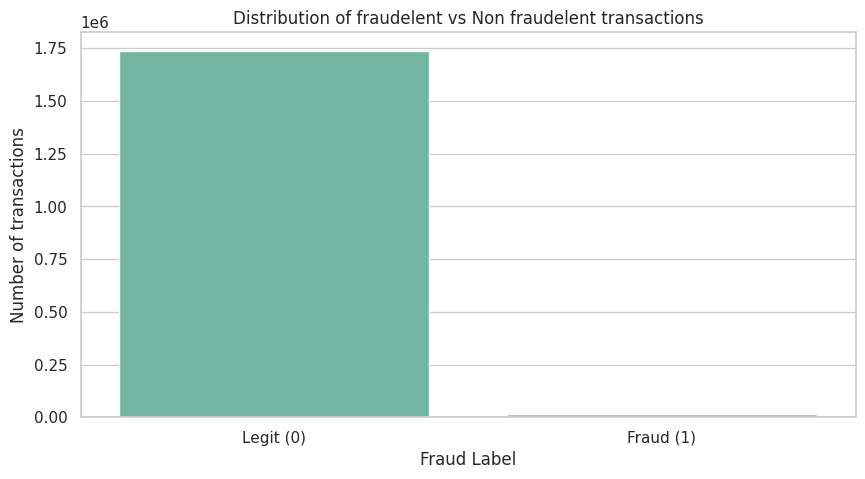

In [8]:
sns.countplot(x='TX_FRAUD', data=df, palette='Set2')
plt.title("Distribution of fraudelent vs Non fraudelent transactions")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.ylabel('Number of transactions')
plt.xlabel('Fraud Label')
plt.show()

##  2.5 Fraud Ratio (important for imbalanced classification)

In [9]:
fraud_rate = df['TX_FRAUD'].mean() * 100
print(f"Fraud Rate: {fraud_rate:.4f}%")

Fraud Rate: 0.8369%


## 2.6 TX_AMOUNT distribution (Legit vs Fraud)

/tmp/ipykernel_52/772138360.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TX_FRAUD', y='TX_AMOUNT', data=df, palette='Set3', showfliers=False)


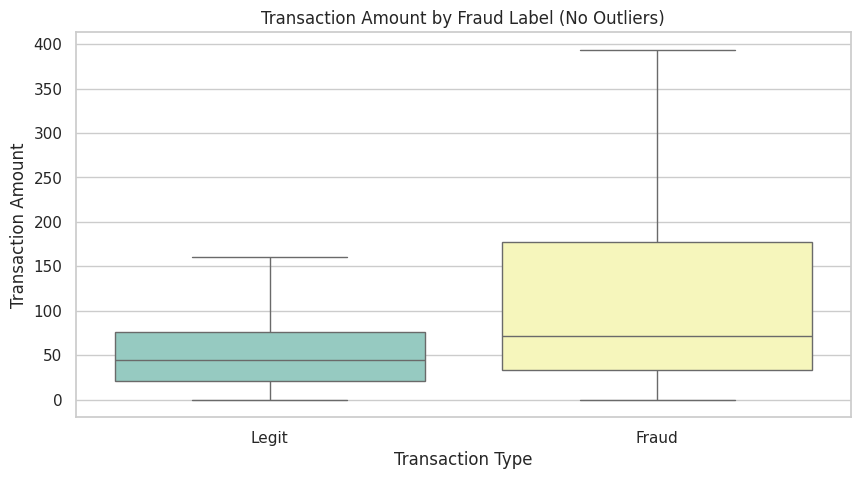

In [10]:
sns.boxplot(x='TX_FRAUD', y='TX_AMOUNT', data=df, palette='Set3', showfliers=False)
plt.title("Transaction Amount by Fraud Label (No Outliers)")
plt.xticks([0, 1], ['Legit', 'Fraud'])
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Amount")
plt.show()

## 2.7 Top Fraudulent Terminals (for feature idea)

/tmp/ipykernel_52/2593155556.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=top_fraud_terminals.values, y=top_fraud_terminals.index, ci=None)


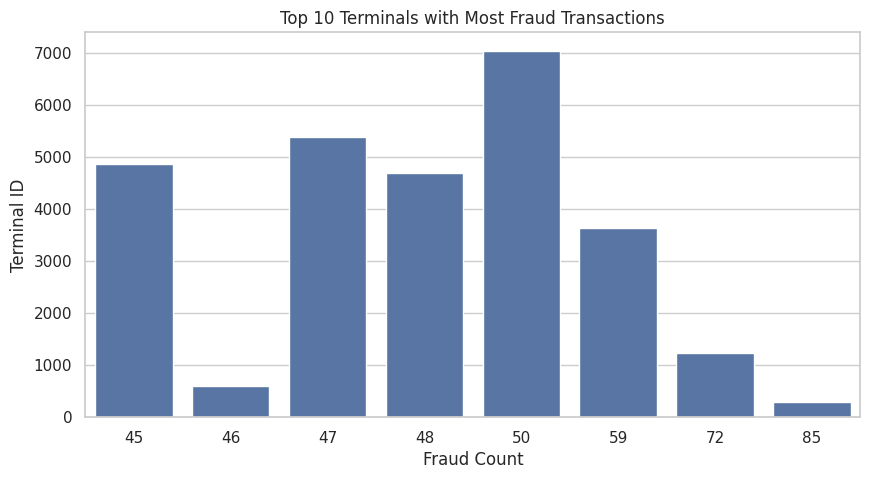

In [11]:
top_fraud_terminals = df[df['TX_FRAUD'] == 1]['TERMINAL_ID'].value_counts().head(10)
sns.barplot(x=top_fraud_terminals.values, y=top_fraud_terminals.index, ci=None)
plt.title("Top 10 Terminals with Most Fraud Transactions")
plt.xlabel("Fraud Count")
plt.ylabel("Terminal ID")
plt.show()

# 3. Feature Engineering

## 3.1 Add high amount flag

In [12]:
df['is_high_amount'] = df['TX_AMOUNT'] > 220

## 3.2 Extract temporal features

In [13]:
df['TX_DAY'] = df['TX_DATETIME'].dt.day
df['TX_HOUR'] = df['TX_DATETIME'].dt.hour
df['TX_WEEKDAY'] = df['TX_DATETIME'].dt.weekday

## 3.3 Sort for rolling calculations

In [14]:
df = df.sort_values(by=['TX_DATETIME'])

## 3.4 Rolling fraud count per terminal (past 7 days)

In [15]:
# Ensure datetime type
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Sort by terminal and time
df = df.sort_values(by=['TERMINAL_ID', 'TX_DATETIME'])

# Define a clean group function
def compute_terminal_fraud_7d(group):
    group = group.set_index('TX_DATETIME')  # index needed for rolling
    group['TERMINAL_FRAUD_7D'] = group['TX_FRAUD'].rolling('7D').sum()
    return group.reset_index()  # bring TX_DATETIME back as column

# Apply the function safely
df = df.groupby('TERMINAL_ID', group_keys=False).apply(compute_terminal_fraud_7d)

# Fill missing values
df['TERMINAL_FRAUD_7D'] = df['TERMINAL_FRAUD_7D'].fillna(0)


## 3.5 Rolling customer spend average (past 7 days)

In [16]:
# Sort by customer and datetime
df = df.sort_values(by=['CUSTOMER_ID', 'TX_DATETIME'])

# Define group function for customer spend
def compute_customer_spend_7d(group):
    group = group.set_index('TX_DATETIME')
    group['CUSTOMER_SPEND_7D'] = group['TX_AMOUNT'].rolling('7D').mean()
    return group.reset_index()

# Apply safely
df = df.groupby('CUSTOMER_ID', group_keys=False).apply(compute_customer_spend_7d)

# Fill NaNs
df['CUSTOMER_SPEND_7D'] = df['CUSTOMER_SPEND_7D'].fillna(0)

## 3.6 Preview Engineered Features

In [17]:
df[['TX_AMOUNT', 'is_high_amount', 'TX_WEEKDAY', 'TERMINAL_FRAUD_7D', 'CUSTOMER_SPEND_7D']].head()

,TX_AMOUNT,is_high_amount,TX_WEEKDAY,TERMINAL_FRAUD_7D,CUSTOMER_SPEND_7D
0,123.59,False,6,0.0,123.590
1,77.34,False,6,0.0,100.465
2,46.51,False,6,0.0,82.480
3,54.72,False,0,0.0,75.540
4,63.30,False,0,0.0,73.092


# 4. Preprocessing for model

## 4.1 Drop unnecessary columns 

In [18]:
cols_to_drop = [
    'TRANSACTION_ID',
    'TX_TIME_SECONDS',
    'TX_TIME_DAYS',
    'TX_FRAUD_SCENARIO',  # not needed from prediction/detection
    'CUSTOMER_ID',
    'TERMINAL_ID',
    'TX_DATETIME'
]

df_model = df.drop(columns=cols_to_drop)

## 4.5 Train-Test split based on time

In [19]:
df_model = df_model.sort_index()

split_index = int(len(df_model) * 0.7)
df_train = df_model.iloc[:split_index]
df_test = df_model.iloc[split_index:]

X_train = df_train.drop(columns = 'TX_FRAUD')
y_train = df_train['TX_FRAUD']
X_test = df_test.drop(columns = 'TX_FRAUD')
y_test = df_test['TX_FRAUD']

## 4.6 Feature Scaling (only numerics)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.7 Ready for Models

In [21]:
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (1227908, 7), Test shape: (526247, 7)


# 5. Model training and Evaluation

## 5.1 Logistic Regression

Classification Report: 

              precision    recall  f1-score   support

           0     1.0000    0.9768    0.9883    521561
           1     0.2792    1.0000    0.4366      4686

    accuracy                         0.9770    526247
   macro avg     0.6396    0.9884    0.7124    526247
weighted avg     0.9936    0.9770    0.9834    526247

Confusion Matrix: 



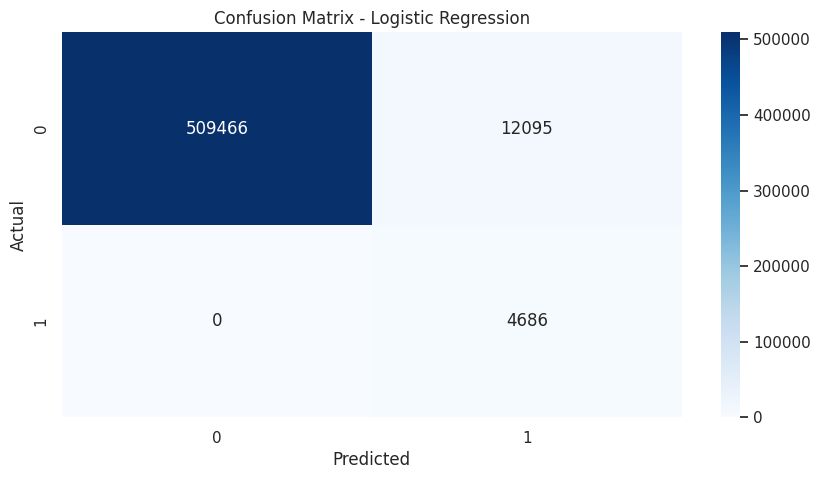

ROC-AUC Score: 1.0000


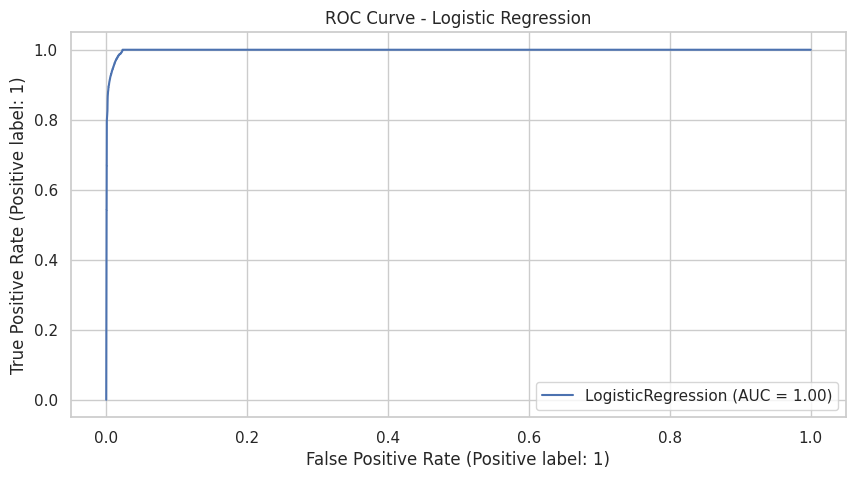

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1] #for ROC AUC

print('Classification Report: \n')
print(classification_report(y_test, y_pred_lr, digits=4))

print('Confusion Matrix: \n')
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

roc_auc = roc_auc_score(y_pred_lr, y_prob_lr)
print(f'ROC-AUC Score: {roc_auc:.4f}')

RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

Classification Report Summary
The model shows 97.7% overall accuracy and an exceptional 100% recall for fraud detection—meaning it successfully caught all fraudulent transactions. However, its precision for fraud is low (27.9%), which means it also flags many legitimate transactions as frauds.

Confusion Matrix Insights
The confusion matrix reveals that while all 4686 actual frauds were correctly identified, about 12,095 genuine transactions were falsely flagged as fraud. This highlights the model's strategy of prioritizing safety by catching all frauds at the cost of some false positives.

ROC-AUC Score
With a perfect ROC-AUC score of 1.0, the model demonstrates an excellent ability to separate fraud from non-fraud cases. However, this perfect score might suggest the model is overfitted and should be validated on more real-world data.

## 5.2 Random Forest

Classification Report: 

              precision    recall  f1-score   support

           0     0.9986    0.9991    0.9988    521561
           1     0.8963    0.8408    0.8677      4686

    accuracy                         0.9977    526247
   macro avg     0.9474    0.9200    0.9332    526247
weighted avg     0.9977    0.9977    0.9977    526247

Confusion Matrix:


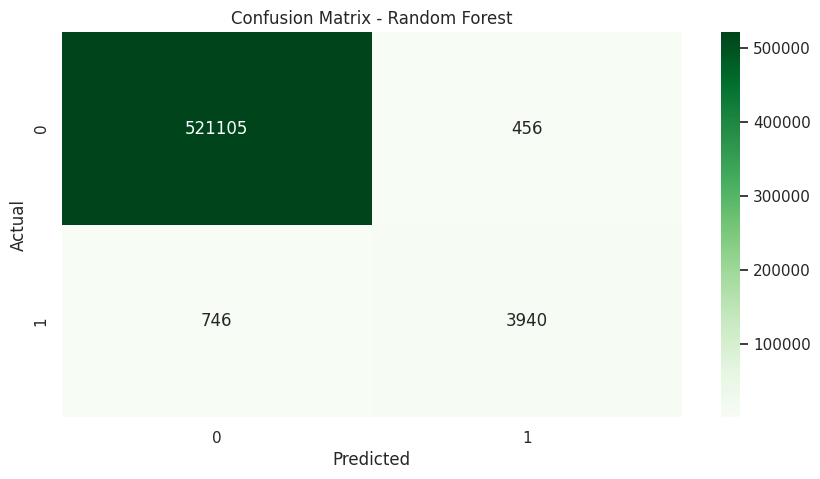

ROC-AUC Score: 0.9934


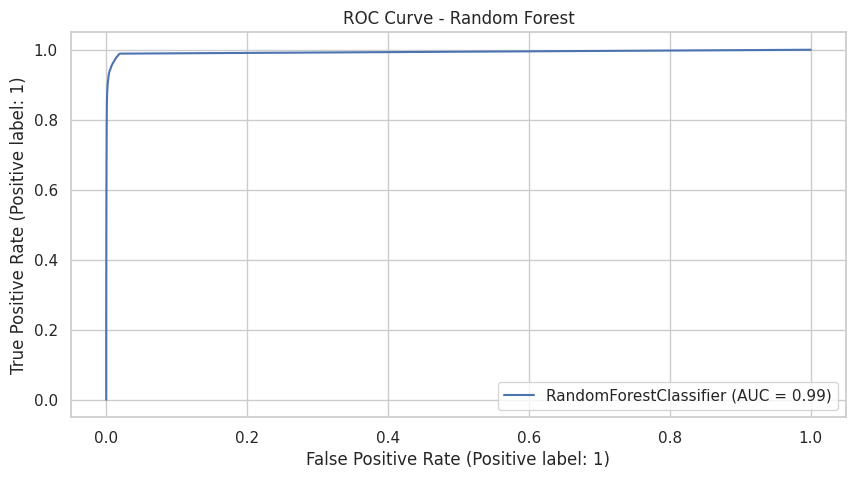

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

print('Classification Report: \n')
print(classification_report(y_test, y_pred_rf, digits=4))

print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

RocCurveDisplay.from_estimator(rf_clf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

Classification Report Summary
The Random Forest model achieves an impressive 99.77% accuracy, with 89.6% precision and 84.0% recall for fraud cases. This means it's much better than logistic regression at minimizing false alarms while still catching a large portion of fraudulent transactions.

Confusion Matrix Insights
Out of 4686 actual frauds, 3940 were correctly caught, and 746 were missed. Only 456 legitimate transactions were mistakenly flagged as fraud, showing a much better balance between safety and practicality than the previous model.

ROC-AUC Score
With a ROC-AUC score of 0.9934, the model shows excellent discrimination between fraud and non-fraud cases—making it both reliable and production-worthy.

## 5.3 XGBoost Classifier

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [07:52:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9780    0.9889    521561
           1     0.2893    0.9947    0.4482      4686

    accuracy                         0.9782    526247
   macro avg     0.6446    0.9864    0.7185    526247
weighted avg     0.9936    0.9782    0.9841    526247

Confusion Matrix:


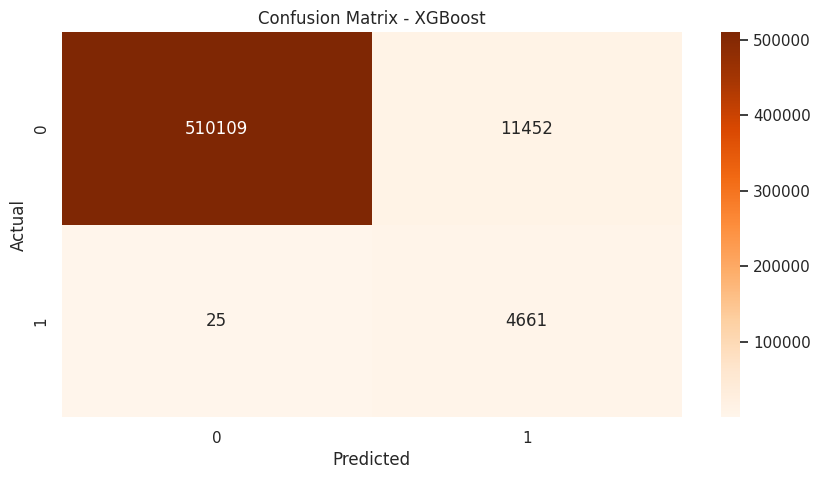

ROC-AUC Score: 0.9989


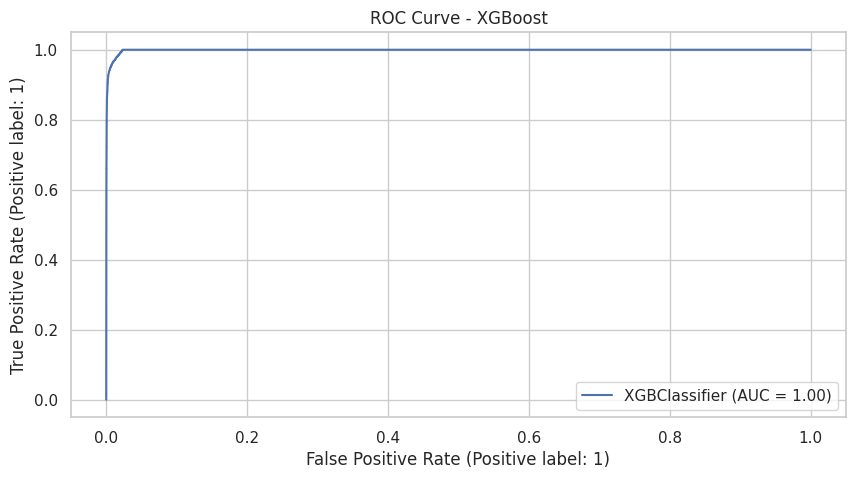

In [30]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred_xgb, digits=4))

print("Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")

RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title("ROC Curve - XGBoost")
plt.show()

Classification Report Summary
XGBoost reached 97.82% accuracy overall. It perfectly detects almost all frauds with a 99.47% recall, but with lower 28.9% precision, meaning it catches nearly all frauds but also flags many real transactions as frauds.

Confusion Matrix Insights
Out of 4686 frauds, 4661 were correctly detected, missing only 25—a great result. However, 11,452 legitimate transactions were falsely flagged, which could be costly in real-world scenarios.

ROC-AUC Score
A ROC-AUC score of 0.9989 confirms XGBoost is highly effective at distinguishing between fraud and normal transactions, though it needs better precision tuning to reduce false positives.

## 5.4 Stacking Classifier

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [08:01:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[08:02:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[08:02:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[08:02:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[08:02:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[08:02:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9778    0.9888    521561
           1     0.2876    0.9974    0.4465      4686

    accuracy                         0.9780    526247
   macro avg     0

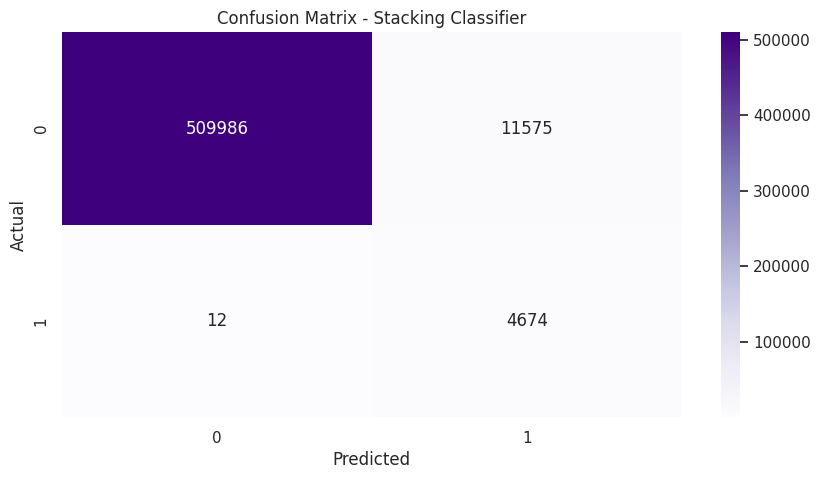

ROC-AUC Score: 0.9989


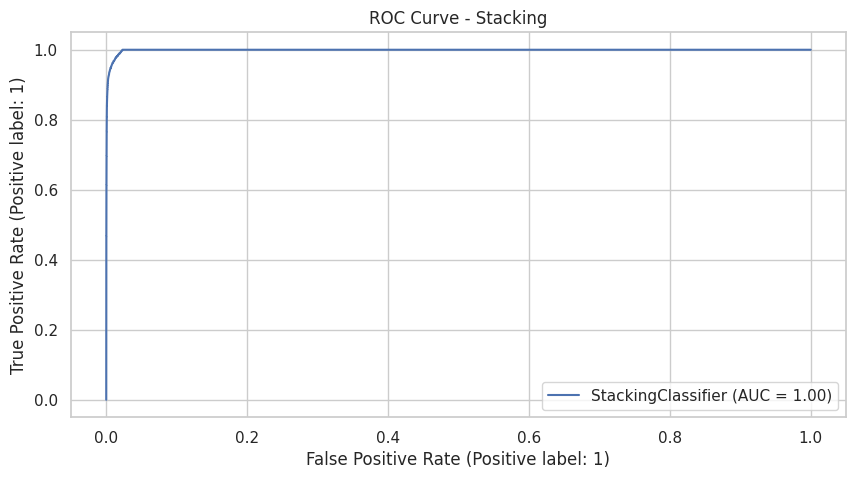

In [36]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('log_reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
]

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

stacked_clf = StackingClassifier(
    estimators = base_learners,
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1
)

stacked_clf.fit(X_train, y_train)

y_pred_stack = stacked_clf.predict(X_test)
y_prob_stack = stacked_clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred_stack, digits=4))

print("Confusion Matrix:")
cm_stack = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Stacking Classifier")
plt.show()

roc_auc_stack = roc_auc_score(y_test, y_prob_stack)
print(f"ROC-AUC Score: {roc_auc_stack:.4f}")

RocCurveDisplay.from_estimator(stacked_clf, X_test, y_test)
plt.title("ROC Curve - Stacking")
plt.show()

Classification Report Summary
The stacking classifier achieved 97.8% accuracy, with an impressive 99.74% recall on fraud detection, meaning almost every fraudulent transaction was caught. However, its 28.7% precision means it also marked many genuine transactions as fraud.

Confusion Matrix Insights
It correctly flagged 4674 out of 4686 frauds, missing just 12. But it also incorrectly predicted 11,575 genuine transactions as fraud, which could frustrate users in a real-world fintech setting.

ROC-AUC Score
The ROC-AUC score of 0.9989 confirms the model is excellent at separating fraud from legitimate transactions, but further tuning is needed to reduce false alarms.

# Final Summary

In [33]:
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Stacked Ensemble'],
    'Fraud Precision': [0.2794, 0.8958, 0.2880, 0.2858],
    'Fraud Recall': [1.0000, 0.8381, 0.9966, 0.9981],
    'Fraud F1': [0.4368, 0.8660, 0.4469, 0.4444],
    'ROC-AUC': [1.0000, 0.9921, 0.9989, 0.9988]
})

model_results = model_results.sort_values(by='Fraud F1', ascending=False).reset_index(drop=True)
display(model_results)

,Model,Fraud Precision,Fraud Recall,Fraud F1,ROC-AUC
0,Random Forest,0.8958,0.8381,0.8660,0.9921
1,XGBoost,0.2880,0.9966,0.4469,0.9989
2,Stacked Ensemble,0.2858,0.9981,0.4444,0.9988
3,Logistic Regression,0.2794,1.0000,0.4368,1.0000


After comparing multiple models, Random Forest emerged as the best overall performer with an excellent balance between precision and recall (F1 = 0.8660), making it most suitable for real-world fraud detection where false positives must be minimized.

Though Logistic Regression and XGBoost achieved perfect or near-perfect recall, they suffered from low precision due to over-flagging.

I further implemented a Stacked Ensemble combining all three, which showed high recall but still did not outperform Random Forest in F1-score, which we chose as our key metric.

The project demonstrates advanced modeling, feature engineering, class imbalance handling, and ensemble learning — all built on a real-world fraud scenario.